In [166]:
import collections
import glob
import os
import csv
import json
import re
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

palette=["#3182bd", "#6baed6", "#9ecae1", "#c6dbef", "#e6550d", "#fd8d3c", "#fdae6b", "#fdd0a2", "#31a354", "#74c476", "#a1d99b", "#c7e9c0", "#756bb1", "#9e9ac8", "#bcbddc", "#dadaeb", "#636363", "#969696", "#bdbdbd", "#d9d9d9"]
colors=palette[0:20:4]

In [13]:
def moving_average_cumsum(a, n=20):
    # Fast, but doesn't play well with NaNs
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

def moving_average(a, n=20):
    return np.convolve(a, np.ones((n,))/n, mode='valid')

def rolling_xs_ys(xs, ys, window_size=20):
    return xs[window_size - 1 :], moving_average(ys, window_size)

In [21]:
def load_path(path):
    xs = []
    ys = []
    
    metafile = path.replace('logs.csv', 'meta.json')
    if os.path.exists(metafile):
        with open(metafile) as f:
            meta = json.load(f)
        name = meta["args"]["env"]
    else:
        match = re.search(r"\w+-v4", path)
        if match:
            name = match.group(0)
        else:
            raise RuntimeError("Couldn't determine name for %s" % path)
    
    with open(path) as f:
        skipped_nans = 0
        reader = csv.reader(f)
        for row in csv.DictReader(f):
            try:
                x, y = float(row['step']), row['mean_episode_return']
            except ValueError as e:
                print("Skipping row in", path, "due to", e)
            if y == "nan":
                skipped_nans += 1
                continue
                
            if x >= 50e6:
                break
            xs.append(x)
            ys.append(float(y))
        #if skipped_nans:
        #    print("Skipped", skipped_nans, "NaNs")
    return name, xs, ys

In [34]:
def get_plotdata(curves):
    xmins = []
    xmaxs = []
    ys_all = []
    for xs, _ in curves:
        xmins.append(min(xs))
        xmaxs.append(max(xs))
    xmin = min(xmins)
    xmax = max(xmaxs)
                
    num_points = 1000
    rxs = np.linspace(xmin, xmax, num_points)
    ys_sum = 0
    counts = 0

    for xs, ys in curves:
        xs, ys = rxs, np.interp(rxs, xs, ys, left=float("nan"), right=float("nan"))
        xs, ys = rolling_xs_ys(xs, ys, window_size=20)
        ys_all.append(ys)
        ys_sum = ys_sum + np.nan_to_num(ys)
        counts = counts + (~np.isnan(ys)).astype(np.float)

    ys_sum = ys_sum / np.clip(counts, 1.0, None)
    
    return xs, ys_sum, ys_all

In [16]:
with open('paper.data.pkl', 'rb') as f:
    paper = pickle.load(f)

In [17]:
envs=[
    "AirRaidNoFrameskip-v4"
    ,"CarnivalNoFrameskip-v4"
    ,"DemonAttackNoFrameskip-v4"
    ,"NameThisGameNoFrameskip-v4"
    ,"PongNoFrameskip-v4"
    ,"SpaceInvadersNoFrameskip-v4"
]

In [59]:
paperdata = dict()
for env in envs:
    paperdata[env] = get_plotdata(paper[env]["torchbeast"])

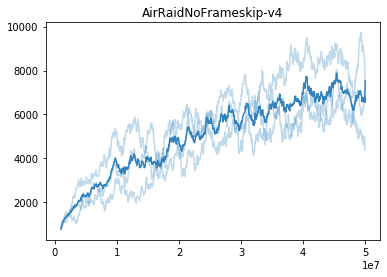

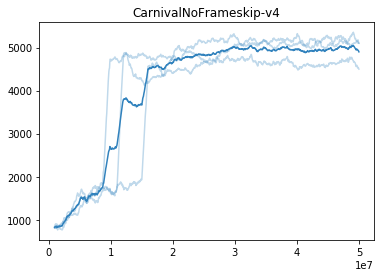

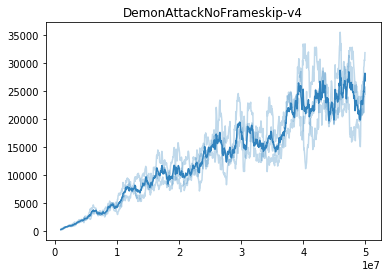

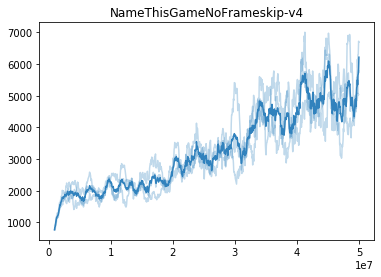

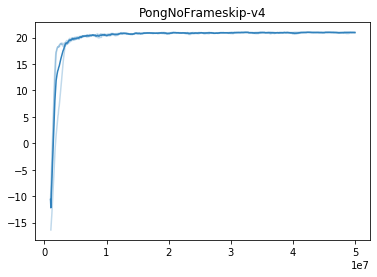

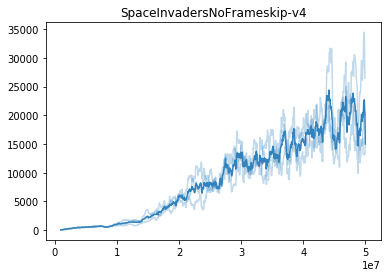

In [155]:
for env in envs:
    plt.plot(paperdata[env][0], paperdata[env][1], color=colors[0])
    for i in range(len(paperdata[env][2])):
        plt.plot(paperdata[env][0], paperdata[env][2][i], alpha=0.3, color=colors[0])
    plt.title(env)
    plt.show()

In [73]:
with open("paper.data.processed.pkl", "wb") as f:
    pickle.dump(paperdata, f)

In [66]:
ourrawdata = dict()
ourdata = dict()
for env in envs:
    _, xs_raw, ys_raw = load_path("../../logs/torchbeast/" + env.replace("NoFrameskip-v4", "") + "/logs.csv")
    ourrawdata[env] =[xs_raw, ys_raw]
    ourdata[env] = get_plotdata([[xs_raw, ys_raw]])

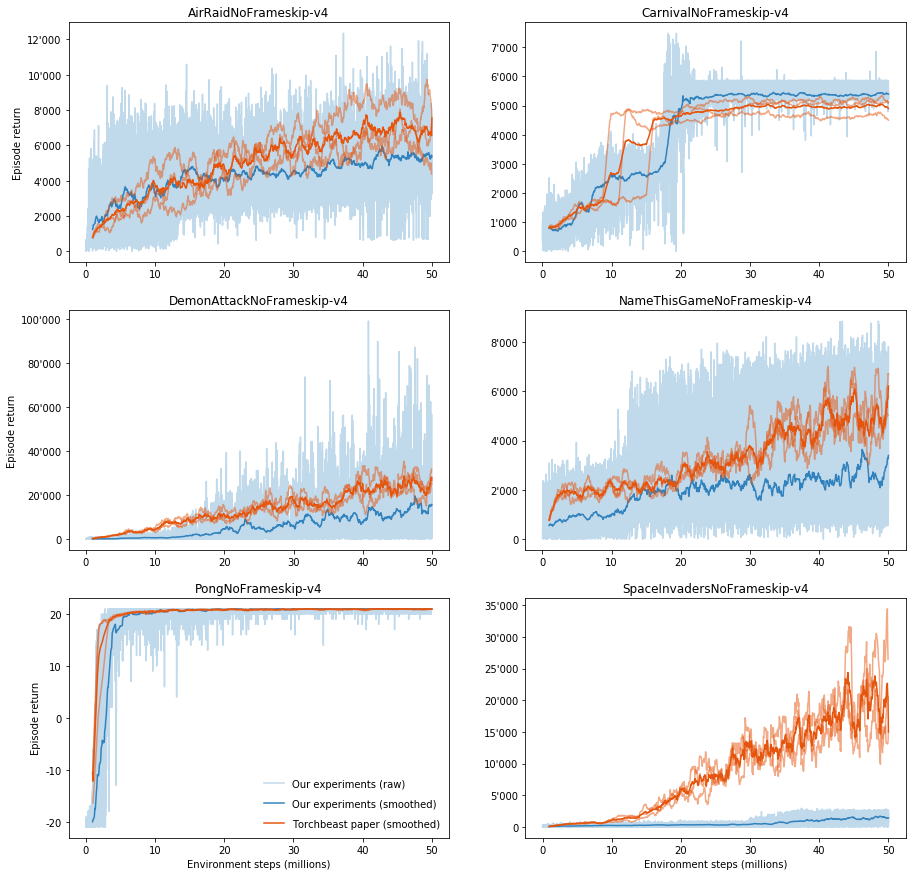

In [191]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
for i in range(3):
    for j in range(2):
        k = i * 2 + j
        env = envs[k]
        axes[i, j].plot(np.array(ourrawdata[env][0]) / 1.e6, ourrawdata[env][1], color=colors[0], alpha=0.3, label="Our experiments (raw)")
        axes[i, j].plot(np.array(ourdata[env][0]) / 1.e6, ourdata[env][1], color=colors[0], label="Our experiments (smoothed)")
        axes[i, j].plot(np.array(paperdata[env][0]) / 1.e6, paperdata[env][1], color=colors[1], label="Torchbeast paper (smoothed)")
        for l in range(len(paperdata[env][2])):
            axes[i, j].plot(np.array(paperdata[env][0]) / 1.e6, paperdata[env][2][l], alpha=0.5, color=colors[1])
        if k == 4:
            axes[i, j].legend(frameon=False, labelspacing=1, loc="upper left" if env != "PongNoFrameskip-v4" else "lower right")
        axes[i, j].title.set_text(envs[k])
        axes[i, j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(",", "\'")))
        if j == 0:
            axes[i, j].set_ylabel('Episode return')
        if i == 2:
            axes[i, j].set_xlabel('Environment steps (millions)')
plt.savefig("../fig_comparison_with_paper.png", bbox_inches="tight")

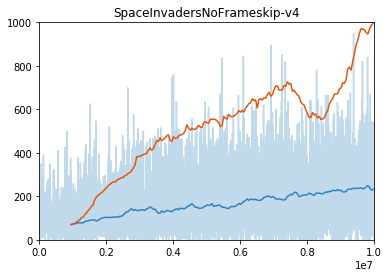

In [157]:
env = "SpaceInvadersNoFrameskip-v4"
plt.plot(ourrawdata[env][0], ourrawdata[env][1], color=colors[0], alpha=0.3)
plt.plot(ourdata[env][0], ourdata[env][1], color=colors[0])
plt.plot(paperdata[env][0], paperdata[env][1], color=colors[1])
plt.xlim(0, 10.e6)
plt.ylim(0, 1000.)
plt.title(env)
plt.show()

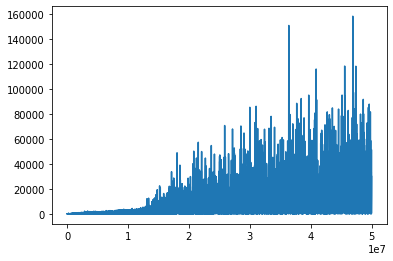

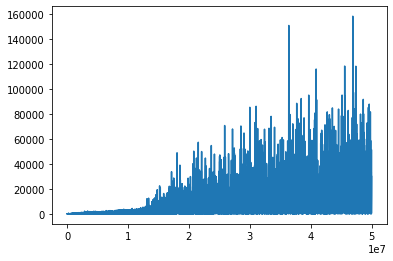

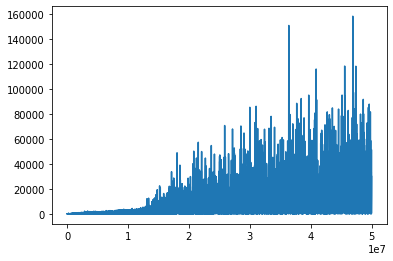

In [150]:
for i in range(3):
    plt.plot(paper[env]["torchbeast"][0][0], paper[env]["torchbeast"][0][1])
    plt.show()

In [209]:
_, xs_raw, ys_raw = load_path("../../logs/torchbeast-local/SpaceInvadersTest/logs.csv")

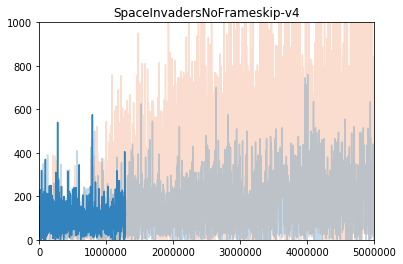

In [210]:
plt.plot(paper[env]["torchbeast"][0][0], paper[env]["torchbeast"][0][1], color=colors[1], alpha=0.2)
plt.plot(ourrawdata[env][0], ourrawdata[env][1], color=colors[0], alpha=0.3)
plt.plot(xs_raw, ys_raw, color=colors[0])
plt.xlim(0, 5.e6)
plt.ylim(0, 1000.)
plt.title(env)
plt.show()